In [ ]:
import logging
logging.disable(logging.WARNING)

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW, DistilBertModel
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from sklearn.model_selection import train_test_split
from tqdm import tqdm  # For progress bars

In [ ]:
# modify to include the address of where your data CSV is
df = pd.read_csv('/content/drive/MyDrive/6.8610/NLP Final Project/top_10000_training_data.csv.gz', compression='gzip')
print(df.head())

    dest_id  source_id   dest_date  \
0  11582807   11781059  1999-08-16   
1  11582807   11781059  1999-08-16   
2  11582807   11781059  1999-08-16   
3  11665092   11781059  1999-07-13   
4  11123976   11781059  2001-03-16   

                                          dest_court  \
0  United States Court of Appeals for the Sixth C...   
1  United States Court of Appeals for the Sixth C...   
2  United States Court of Appeals for the Sixth C...   
3  United States Court of Appeals for the Fifth C...   
4  United States Court of Appeals for the Eighth ...   

                  dest_name                                      dest_cite  \
0  United States v. Houston  United States v. Houston, 187 F.3d 593 (1999)   
1  United States v. Houston  United States v. Houston, 187 F.3d 593 (1999)   
2  United States v. Houston  United States v. Houston, 187 F.3d 593 (1999)   
3     United States v. Ruiz     United States v. Ruiz, 180 F.3d 675 (1999)   
4   United States v. Nation   United States 

In [ ]:
baseline_df = df[['destination_context', 'quote', 'passage_id', 'source_name']]

## 10,000 Data Points, 1.0 Negative Ratio

In [ ]:
# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load pretrained DistilRoBERTa tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('distilroberta-base')

# create a class that creates sentence-pair datasets for training the model
class SentencePairDataset(Dataset):
    def __init__(self, sentences1, sentences2, labels, tokenizer, max_length=128, negative_ratio=1.0):
        self.sentences1 = sentences1
        self.sentences2 = sentences2
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.negative_ratio = negative_ratio

        self._add_negative_samples()

    def _add_negative_samples(self):
        # lists for adding new sentences
        new_sentences1 = []
        new_sentences2 = []
        new_labels = []

        # add original data (positive samples)
        new_sentences1.extend(self.sentences1)
        new_sentences2.extend(self.sentences2)
        new_labels.extend(self.labels)

        # determine the number of negative samples to add (for the 'for' loop)
        num_negatives = int(len(self.sentences1) * self.negative_ratio)

        # negative samples 'for' loop
        for i in range(num_negatives):
            # randomly sample two sentences from the dataset to form a negative pair
            idx1, idx2 = random.sample(range(len(self.sentences1)), 2)
            negative_sentence1 = self.sentences1[idx1]
            negative_sentence2 = self.sentences2[idx2]

            # append negative sample with label 0.0
            new_sentences1.append(negative_sentence1)
            new_sentences2.append(negative_sentence2)
            new_labels.append(0.0)

        # change dataset to the new list that has both positive and negative samples
        self.sentences1 = new_sentences1
        self.sentences2 = new_sentences2
        self.labels = new_labels

    def __len__(self):
        return len(self.sentences1)

    def __getitem__(self, idx):
        sentence1 = self.sentences1[idx]
        sentence2 = self.sentences2[idx]
        label = self.labels[idx]

        # tokenize and encode the sentence1 and sentence2 pair
        encoding = self.tokenizer.encode_plus(
            sentence1,
            sentence2,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        # return the encoding and the attention mask and labels
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float)
        }

# create custom class for DistilRoBERTa cross-encoder
class DistilRoBERTaCrossEncoder(nn.Module):
    def __init__(self):
        super(DistilRoBERTaCrossEncoder, self).__init__()
        self.distilroberta = RobertaForSequenceClassification.from_pretrained('distilroberta-base')
        self.classifier = nn.Linear(self.distilroberta.config.hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        outputs = self.distilroberta(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True
        )
        # pass through all layers
        pooled_output = outputs.hidden_states[-1][:, 0]
        score = self.classifier(pooled_output)
        return self.sigmoid(score)

# load data from the baseline_df
sentences1 = baseline_df["destination_context"].tolist()[:10000]
sentences2 = baseline_df["quote"].tolist()[:10000]
labels = [1.0] * len(sentences1)

# split data into training and validation sets
train_texts1, val_texts1, train_texts2, val_texts2, train_labels, val_labels = train_test_split(
    sentences1, sentences2, labels, test_size=0.2, random_state=42
)

# create a data loader for training and validation
train_dataset = SentencePairDataset(train_texts1, train_texts2, train_labels, tokenizer)
val_dataset = SentencePairDataset(val_texts1, val_texts2, val_labels, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# model, optimizer, loss function (binary cross entropy loss)
model = DistilRoBERTaCrossEncoder()
model = model.to(device)
optimizer = AdamW(model.parameters(), lr=3e-5)
loss_fn = nn.BCELoss()

# train model
def train_epoch(model, data_loader, optimizer, device):
    model.train()
    losses = []

    for d in tqdm(data_loader, desc="Training", leave=False):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.view(-1), labels)
        losses.append(loss.item())

        # optimizer step
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return sum(losses) / len(losses)

# evaluate model
def eval_model(model, data_loader, device):
    model.eval()
    losses = []

    with torch.no_grad():
        for d in tqdm(data_loader, desc="Evaluating", leave=False):
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.view(-1), labels)
            losses.append(loss.item())

    return sum(losses) / len(losses)

# train the model for 20 epochs
epochs = 20
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    train_loss = train_epoch(model, train_loader, optimizer, device)
    print(f"Train loss: {train_loss}")

    val_loss = eval_model(model, val_loader, device)
    print(f"Val loss: {val_loss}")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/20


Train loss: 0.6953317023515702


Val loss: 0.6930278656482697
Epoch 2/20


Train loss: 0.6607731177210808


Val loss: 0.5447800118923187
Epoch 3/20


Train loss: 0.4779252127856016


Val loss: 0.3950233201384544
Epoch 4/20


Train loss: 0.35336988445371387


Val loss: 0.35699760594964025
Epoch 5/20


Train loss: 0.26657531725801525


Val loss: 0.3767783061414957
Epoch 6/20


Train loss: 0.20801772738341243


Val loss: 0.38507871446758507
Epoch 7/20


Train loss: 0.16293910299381242


Val loss: 0.3513390631824732
Epoch 8/20


Train loss: 0.13016875556786545


Val loss: 0.47486424158886076
Epoch 9/20


Train loss: 0.1090867606139509


Val loss: 0.4286515588313341
Epoch 10/20


Train loss: 0.09604426294704899


Val loss: 0.5206382988577243
Epoch 11/20


Train loss: 0.079132258588681


Val loss: 0.4825601018331945
Epoch 12/20


Train loss: 0.07306972949812189


Val loss: 0.6044529897013563
Epoch 13/20


Train loss: 0.06483436756813898


Val loss: 0.49430914255604147
Epoch 14/20


Train loss: 0.059183350819163025


Val loss: 0.4966330675017089
Epoch 15/20


Train loss: 0.05449511621019337


Val loss: 0.5588938115746714
Epoch 16/20


Train loss: 0.04947382211207878


Val loss: 0.5291033760961145
Epoch 17/20


Train loss: 0.0468760102079832


Val loss: 0.5318992769980104
Epoch 18/20


Train loss: 0.04377155140892137


Val loss: 0.6164721959950402
Epoch 19/20


Train loss: 0.044075192931923086


Val loss: 0.5750835170180071
Epoch 20/20


Train loss: 0.03594876857911004


Val loss: 0.6124782339143566


## 10,000 Data Points, 4.0 Negative Ratio

In [ ]:
# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load pretrained DistilRoBERTa tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('distilroberta-base')

# create a class that creates sentence-pair datasets for training the model
class SentencePairDataset(Dataset):
    def __init__(self, sentences1, sentences2, labels, tokenizer, max_length=128, negative_ratio=4.0):
        self.sentences1 = sentences1
        self.sentences2 = sentences2
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.negative_ratio = negative_ratio

        self._add_negative_samples()

    def _add_negative_samples(self):
        # lists for adding new sentences
        new_sentences1 = []
        new_sentences2 = []
        new_labels = []

        # add original data (positive samples)
        new_sentences1.extend(self.sentences1)
        new_sentences2.extend(self.sentences2)
        new_labels.extend(self.labels)

        # determine the number of negative samples to add (for the 'for' loop)
        num_negatives = int(len(self.sentences1) * self.negative_ratio)

        # negative samples 'for' loop
        for i in range(num_negatives):
            # randomly sample two sentences from the dataset to form a negative pair
            idx1, idx2 = random.sample(range(len(self.sentences1)), 2)
            negative_sentence1 = self.sentences1[idx1]
            negative_sentence2 = self.sentences2[idx2]

            # append negative sample with label 0.0
            new_sentences1.append(negative_sentence1)
            new_sentences2.append(negative_sentence2)
            new_labels.append(0.0)

        # change dataset to the new list that has both positive and negative samples
        self.sentences1 = new_sentences1
        self.sentences2 = new_sentences2
        self.labels = new_labels

    def __len__(self):
        return len(self.sentences1)

    def __getitem__(self, idx):
        sentence1 = self.sentences1[idx]
        sentence2 = self.sentences2[idx]
        label = self.labels[idx]

        # tokenize and encode the sentence1 and sentence2 pair
        encoding = self.tokenizer.encode_plus(
            sentence1,
            sentence2,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        # return the encoding and the attention mask and labels
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float)
        }

# create custom class for DistilRoBERTa cross-encoder
class DistilRoBERTaCrossEncoder(nn.Module):
    def __init__(self):
        super(DistilRoBERTaCrossEncoder, self).__init__()
        self.distilroberta = RobertaForSequenceClassification.from_pretrained('distilroberta-base')
        self.classifier = nn.Linear(self.distilroberta.config.hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        outputs = self.distilroberta(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True
        )
        # pass through all layers
        pooled_output = outputs.hidden_states[-1][:, 0]
        score = self.classifier(pooled_output)
        return self.sigmoid(score)

# load data from the baseline_df
sentences1 = baseline_df["destination_context"].tolist()[:10000]
sentences2 = baseline_df["quote"].tolist()[:10000]
labels = [1.0] * len(sentences1)

# split data into training and validation sets
train_texts1, val_texts1, train_texts2, val_texts2, train_labels, val_labels = train_test_split(
    sentences1, sentences2, labels, test_size=0.2, random_state=42
)

# create a data loader for training and validation
train_dataset = SentencePairDataset(train_texts1, train_texts2, train_labels, tokenizer)
val_dataset = SentencePairDataset(val_texts1, val_texts2, val_labels, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# model, optimizer, loss function (binary cross entropy loss)
model = DistilRoBERTaCrossEncoder()
model = model.to(device)
optimizer = AdamW(model.parameters(), lr=3e-5)
loss_fn = nn.BCELoss()

# train model
def train_epoch(model, data_loader, optimizer, device):
    model.train()
    losses = []

    for d in tqdm(data_loader, desc="Training", leave=False):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.view(-1), labels)
        losses.append(loss.item())

        # optimizer step
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return sum(losses) / len(losses)

# evaluate model
def eval_model(model, data_loader, device):
    model.eval()
    losses = []

    with torch.no_grad():
        for d in tqdm(data_loader, desc="Evaluating", leave=False):
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.view(-1), labels)
            losses.append(loss.item())

    return sum(losses) / len(losses)

# train the model for 10 epochs
epochs = 10
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    train_loss = train_epoch(model, train_loader, optimizer, device)
    print(f"Train loss: {train_loss}")

    val_loss = eval_model(model, val_loader, device)
    print(f"Val loss: {val_loss}")

NameError: name 'torch' is not defined

## 200,000 Data Points, 4.0 Negative Ratio

In [ ]:
# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load pretrained DistilRoBERTa tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('distilroberta-base')

# create a class that creates sentence-pair datasets for training the model
class SentencePairDataset(Dataset):
    def __init__(self, sentences1, sentences2, labels, tokenizer, max_length=128, negative_ratio=4.0):
        self.sentences1 = sentences1
        self.sentences2 = sentences2
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.negative_ratio = negative_ratio

        self._add_negative_samples()

    def _add_negative_samples(self):
        # lists for adding new sentences
        new_sentences1 = []
        new_sentences2 = []
        new_labels = []

        # add original data (positive samples)
        new_sentences1.extend(self.sentences1)
        new_sentences2.extend(self.sentences2)
        new_labels.extend(self.labels)

        # determine the number of negative samples to add (for the 'for' loop)
        num_negatives = int(len(self.sentences1) * self.negative_ratio)

        # negative samples 'for' loop
        for _ in range(num_negatives):
            # randomly sample two sentences from the dataset to form a negative pair
            idx1, idx2 = random.sample(range(len(self.sentences1)), 2)
            negative_sentence1 = self.sentences1[idx1]
            negative_sentence2 = self.sentences2[idx2]

            # append negative sample with label 0.0
            new_sentences1.append(negative_sentence1)
            new_sentences2.append(negative_sentence2)
            new_labels.append(0.0)

        # change dataset to the new list that has both positive and negative samples
        self.sentences1 = new_sentences1
        self.sentences2 = new_sentences2
        self.labels = new_labels

    def __len__(self):
        return len(self.sentences1)

    def __getitem__(self, idx):
        sentence1 = self.sentences1[idx]
        sentence2 = self.sentences2[idx]
        label = self.labels[idx]

        # tokenize and encode the sentence1 and sentence2 pair
        encoding = self.tokenizer.encode_plus(
            sentence1,
            sentence2,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        # return the encoding and the attention mask and labels
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float)
        }

# create custom class for DistilRoBERTa cross-encoder
class DistilRoBERTaCrossEncoder(nn.Module):
    def __init__(self):
        super(DistilRoBERTaCrossEncoder, self).__init__()
        self.distilroberta = RobertaForSequenceClassification.from_pretrained('distilroberta-base')
        self.classifier = nn.Linear(self.distilroberta.config.hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        outputs = self.distilroberta(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True
        )
        # pass through all layers
        pooled_output = outputs.hidden_states[-1][:, 0]
        score = self.classifier(pooled_output)
        return self.sigmoid(score)

# load data from the baseline_df
sentences1 = baseline_df["destination_context"].tolist()[50000:200000]
sentences2 = baseline_df["quote"].tolist()[50000:200000]
labels = [1.0] * len(sentences1)

# split data to make test set
initial_texts1, test_texts1, initial_texts2, test_texts2, initial_labels, test_labels = train_test_split(
    sentences1, sentences2, labels, test_size=0.01, random_state=42
)
# split remaining data to make training and validation sets
train_texts1, val_texts1, train_texts2, val_texts2, train_labels, val_labels = train_test_split(
    initial_texts1, initial_texts2, initial_labels, test_size=0.2, random_state=42
)

# create data loaders for training, validation, and testing
train_dataset = SentencePairDataset(train_texts1, train_texts2, train_labels, tokenizer)
val_dataset = SentencePairDataset(val_texts1, val_texts2, val_labels, tokenizer)
test_dataset = SentencePairDataset(test_texts1, test_texts2, test_labels, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# model, optimizer, loss function (binary cross entropy loss)
model = DistilRoBERTaCrossEncoder()

# comment out if needed
model.load_state_dict(torch.load('/content/drive/MyDrive/6.8610/NLP Final Project/cross_encoder.pth', weights_only=True))
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.BCELoss()

# train model
def train_epoch(model, data_loader, optimizer, device):
    model.train()
    losses = []

    for d in tqdm(data_loader, desc="Training", leave=False):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.view(-1), labels)
        losses.append(loss.item())

        # optimizer step
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return sum(losses) / len(losses)

# evaluate model
def eval_model(model, data_loader, device):
    model.eval()
    losses = []

    with torch.no_grad():
        for d in tqdm(data_loader, desc="Evaluating", leave=False):
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.view(-1), labels)
            losses.append(loss.item())

    return sum(losses) / len(losses)

# train the model for 1 epoch
epochs = 1
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    train_loss = train_epoch(model, train_loader, optimizer, device)
    print(f"Train loss: {train_loss}")

    val_loss = eval_model(model, val_loader, device)
    print(f"Val loss: {val_loss}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/1


Train loss: 0.19727122778515097


Val loss: 0.16509189550437123


In [ ]:
def test_model(model, test_texts1, test_texts2, test_labels, tokenizer, max_length=128):
    """
    Test the model on a list of sentence pairs and print the similarity scores.

    Args:
        model: The trained cross-encoder model.
        sentence_pairs: List of tuples containing sentence pairs [(sentence1, sentence2), ...].
        tokenizer: Tokenizer used for preprocessing.
        max_length: Maximum token length for the tokenizer.
        labels: (Optional) List of actual similarity scores for the sentence pairs.
                If provided, will print the actual similarity score alongside the predicted score.
    """
    # set the model to evaluation mode
    model.eval()
    results = []

    print("Testing model on sentence pairs:\n")
    with torch.no_grad():
        for idx, sentence1 in enumerate(test_texts1[0:10]):

            # encode and tokenize the sentence pair
            encoding = tokenizer.encode_plus(
                sentence1,
                test_texts2[idx],
                add_special_tokens=True,
                max_length=max_length,
                return_token_type_ids=False,
                padding='max_length',
                truncation=True,
                return_attention_mask=True,
                return_tensors='pt'
            )

            # put tensors on the same device
            input_ids = encoding['input_ids'].to(device)
            attention_mask = encoding['attention_mask'].to(device)

            # calculate similarity score for context-quotation pair
            output = model(input_ids=input_ids, attention_mask=attention_mask)
            predicted_score = output.item()

            # get label
            actual_score = test_labels[idx] if labels else None

            # print result
            print(f"Sentence 1: {sentence1}")
            print(f"Sentence 2: {test_texts2[idx]}")
            print(f"Predicted Similarity Score: {predicted_score:.4f}")
            if actual_score is not None:
                print(f"Actual Similarity Score: {actual_score:.4f}")
            print()

            results.append((sentence1, test_texts2[idx], predicted_score, actual_score))

    return results

test_model(model, test_dataset.sentences1, test_dataset.sentences2, test_dataset.labels, test_dataset.tokenizer, test_dataset.max_length)

Testing model on sentence pairs:

Sentence 1:  Fed.R.Evid. 404(b). “First, it must be determined that the extrinsic offense evidence is relevant to an issue other than the defendant’s character.
Sentence 2: First, it must be determined that the extrinsic offense evidence is relevant to an issue other than the defendant’s character. Second, the evidence must possess probative value that is not substantially outweighed by its undue prejudice and must meet the other requirements of [R]ule 403.
Predicted Similarity Score: 0.9904
Actual Similarity Score: 1.0000

Sentence 1:  Angelene therefore continues to suffer the same injury that she sustained at the outset of the litigation: denial of a legal entitlement to a two-bedroom voucher, which renders her perpetually vulnerable to having that voucher revoked. Consequently, her claims are not moot. For a case to be rendered moot through the defendant’s voluntary cessation of a challenged practice, it must be “
Sentence 2: absolutely clear that 

[(' Fed.R.Evid. 404(b). “First, it must be determined that the extrinsic offense evidence is relevant to an issue other than the defendant’s character.',
  'First, it must be determined that the extrinsic offense evidence is relevant to an issue other than the defendant’s character. Second, the evidence must possess probative value that is not substantially outweighed by its undue prejudice and must meet the other requirements of [R]ule 403.',
  0.9903901815414429,
  1.0),
 (' Angelene therefore continues to suffer the same injury that she sustained at the outset of the litigation: denial of a legal entitlement to a two-bedroom voucher, which renders her perpetually vulnerable to having that voucher revoked. Consequently, her claims are not moot. For a case to be rendered moot through the defendant’s voluntary cessation of a challenged practice, it must be “',
  'absolutely clear that the allegedly wrongful behavior could not reasonably be expected to recur.',
  0.9943695664405823,
  1

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/6.8610/NLP Final Project/cross_encoder.pth')

## Loading and Working with Model

In [ ]:
# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load pretrained DistilRoBERTa tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('distilroberta-base')

# create a class that creates sentence-pair datasets for training the model
class SentencePairDataset(Dataset):
    def __init__(self, sentences1, sentences2, cases, labels, tokenizer, max_length=128):
        self.sentences1 = sentences1
        self.sentences2 = sentences2
        self.cases = cases
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.sentences1)

    def __getitem__(self, idx):
        sentence1 = self.sentences1[idx]
        sentence2 = self.sentences2[idx]
        label = self.labels[idx]

        # tokenize and encode the sentence1 and sentence2 pair
        encoding = self.tokenizer.encode_plus(
            sentence1,
            sentence2,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float)
        }

# create custom class for DistilRoBERTa cross-encoder
class DistilRoBERTaCrossEncoder(nn.Module):
    def __init__(self):
        super(DistilRoBERTaCrossEncoder, self).__init__()
        self.distilroberta = RobertaForSequenceClassification.from_pretrained('distilroberta-base')
        self.classifier = nn.Linear(self.distilroberta.config.hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        outputs = self.distilroberta(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True
        )
        pooled_output = outputs.hidden_states[-1][:, 0]  # CLS token
        score = self.classifier(pooled_output)
        return self.sigmoid(score)

# load data from the baseline_df
sentences1 = baseline_df["destination_context"].tolist()[:200000]
sentences2 = baseline_df["quote"].tolist()[:200000]
cases = baseline_df["source_name"].tolist()[:200000]
labels = [1.0] * len(sentences1)

# split data into training, validation, and testing sets
initial_texts1, test_texts1, initial_texts2, test_texts2, initial_cases, test_cases, initial_labels, test_labels = train_test_split(
    sentences1, sentences2, cases, labels, test_size=0.01, random_state=42
)
train_texts1, val_texts1, train_texts2, val_texts2, train_cases, val_cases, train_labels, val_labels = train_test_split(
    initial_texts1, initial_texts2, initial_cases, initial_labels, test_size=0.2, random_state=42
)

# create test dataset
test_dataset = SentencePairDataset(test_texts1, test_texts2, test_cases, test_labels, tokenizer)

# model base structure created
model = DistilRoBERTaCrossEncoder()
model = model.to(device)

# load pre-existing weights onto the model's base structure
model.load_state_dict(torch.load('/content/drive/MyDrive/6.8610/NLP Final Project/cross_encoder.pth', weights_only=True))
model.eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

DistilRoBERTaCrossEncoder(
  (distilroberta): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0-5): 6 x RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
   

### Test model with randomly-chosen negative samples

In [ ]:
def test_model_with_generated_negatives(model, tokenizer, sentence1_list, sentence2_list, num_negatives=3, max_length=128):

    # set the model to evaluation mode
    model.eval()
    results = []
    correct = 0
    total = 0

    with torch.no_grad():
        for i, (sentence1, correct_sentence2) in enumerate(zip(sentence1_list, sentence2_list)):
            # generate incorrect options for each sentence1 (context)
            negative_samples = random.sample(
                [s for idx, s in enumerate(sentence2_list) if idx != i],
                min(num_negatives, len(sentence2_list) - 1) # set minimum in case there aren't enough options
            )

            # create options list
            all_sentences2 = [correct_sentence2] + negative_samples

            # tokenize all pairs with sentence1
            inputs = tokenizer(
                [sentence1] * len(all_sentences2),
                all_sentences2,
                add_special_tokens=True,
                max_length=max_length,
                return_token_type_ids=False,
                padding="max_length",
                truncation=True,
                return_attention_mask=True,
                return_tensors="pt"
            )

            # move everything to the correct device
            input_ids = inputs["input_ids"].to(device)
            attention_mask = inputs["attention_mask"].to(device)

            # calculate similarity scores
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            scores = outputs.squeeze().cpu().numpy()

            # find the index for the highest score
            predicted_index = scores.argmax()

            # determine if the correct index was in fact chosen
            is_correct = predicted_index == 0
            predicted_sentence2 = all_sentences2[predicted_index]

            # store the result
            results.append((sentence1, correct_sentence2, predicted_sentence2, is_correct))

            # Print the results for this pair
            # print(f"Sentence 1: {sentence1}")
            # print(f"Correct Sentence 2: {correct_sentence2}")
            # for j, (s2, score) in enumerate(zip(all_sentences2, scores)):
            #     print(f"Candidate {j + 1}: {s2} - Score: {score:.4f}")
            # print(f"Predicted Sentence 2: {predicted_sentence2}")
            # print(f"Correct Match: {is_correct}\n")

            if is_correct: correct += 1
            total += 1

    accuracy = correct / total
    print(f"Accuracy: {accuracy * 100:.2f}%")
    return accuracy

random_samples = []
for i in range(1, 20):
    print(f"{i} negative samples:")
    accuracy = test_model_with_generated_negatives(model, test_dataset.tokenizer, test_dataset.sentences1, test_dataset.sentences2, i)
    random_samples.append(accuracy)

1 negative samples:
Accuracy: 96.55%
2 negative samples:
Accuracy: 93.20%
3 negative samples:
Accuracy: 91.80%
4 negative samples:
Accuracy: 90.60%
5 negative samples:
Accuracy: 88.80%
6 negative samples:
Accuracy: 86.70%
7 negative samples:
Accuracy: 85.75%
8 negative samples:
Accuracy: 84.10%
9 negative samples:
Accuracy: 84.15%
10 negative samples:
Accuracy: 83.05%
11 negative samples:
Accuracy: 82.90%
12 negative samples:
Accuracy: 81.25%
13 negative samples:
Accuracy: 80.75%
14 negative samples:
Accuracy: 79.65%
15 negative samples:
Accuracy: 79.30%
16 negative samples:
Accuracy: 78.95%
17 negative samples:
Accuracy: 77.40%
18 negative samples:
Accuracy: 77.10%
19 negative samples:
Accuracy: 75.55%


### Test model by pulling a sample of passages from case

In [ ]:
def test_model_with_case_quotes(model, tokenizer, sentence1_list, sentence2_list, case_list, all_quotes, all_cases, num_samples=9, max_length=128):

    # set the model to evaluation mode
    model.eval()
    results = []
    correct = 0
    total = 0

    with torch.no_grad():
        for i, (sentence1, correct_sentence2) in enumerate(zip(sentence1_list, sentence2_list)):

            # generate incorrect options for each sentence1 (context) but only from the case that the quote is in
            all_possible_quotes = [quote for quote, case_name in zip(all_quotes, all_cases) if (case_name == case_list[i] and quote != correct_sentence2)]
            possible_quotes = random.sample(
                all_possible_quotes, min(num_samples, len(all_possible_quotes) - 1)
            )

            # create options list
            all_sentences2 = [correct_sentence2] + possible_quotes

            # tokenize all pairs with sentence1
            inputs = tokenizer(
                [sentence1] * len(all_sentences2),
                all_sentences2,
                add_special_tokens=True,
                max_length=max_length,
                return_token_type_ids=False,
                padding="max_length",
                truncation=True,
                return_attention_mask=True,
                return_tensors="pt"
            )

            # move everything to the correct device
            input_ids = inputs["input_ids"].to(device)
            attention_mask = inputs["attention_mask"].to(device)

            # calculate similarity scores
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            scores = outputs.squeeze().cpu().numpy()

            # find the index for the highest score
            predicted_index = scores.argmax()

            # determine if the correct index was in fact chosen
            is_correct = predicted_index == 0
            predicted_sentence2 = all_sentences2[predicted_index]

            # store the result
            results.append((sentence1, correct_sentence2, predicted_sentence2, is_correct))

            # Print the results for this pair
            # print(f"Sentence 1: {sentence1}")
            # print(f"Correct Sentence 2: {correct_sentence2}")
            # for j, (s2, score) in enumerate(zip(all_sentences2, scores)):
            #     print(f"Candidate {j + 1}: {s2} - Score: {score:.4f}")
            # print(f"Predicted Sentence 2: {predicted_sentence2}")
            # print(f"Correct Match: {is_correct}\n")

            if is_correct: correct += 1
            total += 1

    accuracy = correct / total
    print(f"Accuracy: {accuracy * 100:.2f}%")
    return accuracy


case_samples = []
for i in range(1, 20):
    print(f"{i + 1} options from case:")
    accuracy = test_model_with_case_quotes(model, test_dataset.tokenizer, test_dataset.sentences1, test_dataset.sentences2, test_dataset.cases, sentences2, cases, i)
    case_samples.append(accuracy)

2 options from case:
Accuracy: 76.40%
3 options from case:
Accuracy: 65.65%
4 options from case:
Accuracy: 58.60%
5 options from case:
Accuracy: 53.30%
6 options from case:
Accuracy: 51.80%
7 options from case:
Accuracy: 47.95%
8 options from case:
Accuracy: 45.50%
9 options from case:
Accuracy: 44.50%
10 options from case:
Accuracy: 42.40%
11 options from case:
Accuracy: 40.90%
12 options from case:
Accuracy: 40.15%
13 options from case:
Accuracy: 38.00%
14 options from case:
Accuracy: 36.65%
15 options from case:
Accuracy: 35.85%
16 options from case:
Accuracy: 36.05%
17 options from case:
Accuracy: 34.10%
18 options from case:
Accuracy: 33.95%
19 options from case:
Accuracy: 33.70%
20 options from case:
Accuracy: 32.00%


### Analysis

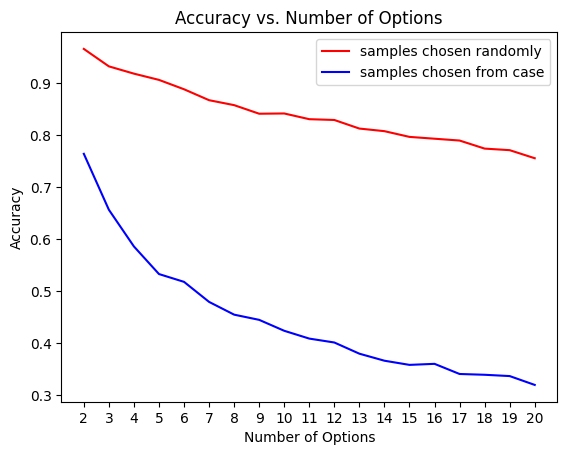

In [ ]:
import matplotlib.pyplot as plt

num_options = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

# plot accuracy vs. number of options
plt.plot(num_options, random_samples, label='samples chosen randomly', color="red")
plt.plot(num_options, case_samples, label='samples chosen from case',color="blue")
plt.xticks(range(2,21))
plt.legend()
plt.xlabel('Number of Options')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Options')
plt.show()